In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
def build_map(df, col_name):
    key = df[col_name].unique().tolist()
    m = dict(zip(key, range(len(key))))
    df[col_name] = df[col_name].map(lambda x: m[x])
    return df

In [2]:
import json
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

### Read

In [3]:
train_data = pd.read_csv('train.csv')
train_data.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [4]:
train_data.columns# columns of dataframe

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

In [5]:
#extract some columns
#'srch_id': search request
#'prop_id': hotel ID
#'booking_bool': if the recommended hotel is booked
#'srch_destination_id': destination ID of the search 
#six features of hotels: 'prop_brand_bool', 'prop_starrating', 'prop_review_score',  'prop_location_score1', 'prop_log_historical_price','price_usd'
train_data = train_data[['date_time', 'srch_id', 'prop_id', 'booking_bool', 'srch_destination_id', 
                         'prop_brand_bool', 'prop_starrating', 'prop_review_score', 
                         'prop_location_score1', 'prop_log_historical_price', 'price_usd',
                         'srch_length_of_stay', 'srch_booking_window',
                         'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score']]
train_data['day'] = pd.to_datetime(train_data['date_time']).dt.date

### Select destination 8192

In [6]:
train_data['count'] = 1
count = train_data[['srch_destination_id','count']]
count = count.groupby('srch_destination_id').sum()
count.sort_values(by="count",ascending=False)[0:10] 
des8192 = train_data[train_data['srch_destination_id']==8192]
des8192 = des8192.drop(columns=['srch_destination_id','count'])
print('unique srch number: ',len(des8192['srch_id'].unique()))
des8192['prop_review_score'].fillna(des8192['prop_review_score'].mean(), inplace=True)
des8192.head()#目的地ID 8192有关的记录
len(des8192['prop_id'].unique())###这个提取的数据集中总共的hotel数量有126个
len(des8192['srch_id'].unique())

,count
srch_destination_id,
8192,140182
4562,114350
9402,82842
10979,69369
8347,64198
13292,63602
13870,60151
18774,53072
23904,52679


unique srch number:  4925


/tmp/ipykernel_2321169/1410973598.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  des8192['prop_review_score'].fillna(des8192['prop_review_score'].mean(), inplace=True)


,date_time,srch_id,prop_id,booking_bool,prop_brand_bool,prop_starrating,prop_review_score,prop_location_score1,prop_log_historical_price,price_usd,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,day
737,2013-05-23 11:56:25,63,14082,0,1,4,4.0,4.29,5.35,107.71,4,25,3,0,1,0,NaN,2013-05-23
738,2013-05-23 11:56:25,63,24545,0,0,4,4.0,4.04,5.20,92.19,4,25,3,0,1,0,NaN,2013-05-23
739,2013-05-23 11:56:25,63,38419,0,1,5,4.0,4.19,5.61,128.09,4,25,3,0,1,0,NaN,2013-05-23
740,2013-05-23 11:56:25,63,40279,0,1,5,4.5,4.29,5.96,164.97,4,25,3,0,1,0,NaN,2013-05-23
741,2013-05-23 11:56:25,63,46274,0,1,5,4.5,4.08,5.89,141.68,4,25,3,0,1,0,NaN,2013-05-23


126

4925

In [7]:
df = des8192.drop(columns=['srch_query_affinity_score'])
df.isna().sum()

date_time                    0
srch_id                      0
prop_id                      0
booking_bool                 0
prop_brand_bool              0
prop_starrating              0
prop_review_score            0
prop_location_score1         0
prop_log_historical_price    0
price_usd                    0
srch_length_of_stay          0
srch_booking_window          0
srch_adults_count            0
srch_children_count          0
srch_room_count              0
srch_saturday_night_bool     0
day                          0
dtype: int64

### Normalize features

In [8]:
#prop_cols = ['prop_id','prop_brand_bool','prop_starrating','prop_review_score','prop_location_score1','prop_log_historical_price','price_usd']
#prop_record = des8192[prop_cols]
#prop_info = prop_record.groupby('prop_id').mean()

for col in ['prop_starrating','prop_review_score','prop_location_score1','prop_log_historical_price','price_usd']:
    df[col]=(df[col]-df[col].mean())/(df[col].var()**0.5)
for col in ['srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count']:
    df[col]=(df[col]-df[col].mean())/(df[col].var()**0.5)

df_normalized = df.copy()

In [9]:
for col in ['prop_starrating','prop_review_score','prop_location_score1','prop_log_historical_price','price_usd',
           'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 
         'srch_children_count', 'srch_room_count']:
    df_normalized.loc[df_normalized[col] < df_normalized[col].quantile(0.1),col]= df_normalized[col].quantile(0.1)
    df_normalized.loc[df_normalized[col] > df_normalized[col].quantile(0.9),col] = df_normalized[col].quantile(0.9)
    df_normalized[col].describe()

count    140182.000000
mean          0.036427
std           0.928422
min          -1.213400
25%          -1.213400
50%          -0.007065
75%           1.199270
max           1.199270
Name: prop_starrating, dtype: float64

count    140182.000000
mean          0.003335
std           0.792391
min          -1.177139
25%          -0.124085
50%          -0.124085
75%           0.928968
max           0.928968
Name: prop_review_score, dtype: float64

count    140182.000000
mean          0.092172
std           0.764923
min          -1.402552
25%          -0.284167
50%           0.307920
75%           0.702644
max           0.932900
Name: prop_location_score1, dtype: float64

count    140182.000000
mean         -0.003130
std           0.997824
min          -2.706547
25%           0.103976
50%           0.304728
75%           0.511216
max           0.671817
Name: prop_log_historical_price, dtype: float64

count    140182.000000
mean         -0.055808
std           0.326088
min          -0.464894
25%          -0.347893
50%          -0.116694
75%           0.214239
max           0.513439
Name: price_usd, dtype: float64

count    140182.000000
mean         -0.129729
std           0.634716
min          -1.016563
25%          -0.409404
50%          -0.409404
75%           0.197755
max           0.804914
Name: srch_length_of_stay, dtype: float64

count    140182.000000
mean         -0.096563
std           0.733446
min          -0.811024
25%          -0.690461
50%          -0.363221
75%           0.291260
max           1.427991
Name: srch_booking_window, dtype: float64

count    140182.000000
mean         -0.056750
std           0.805588
min          -1.191121
25%          -0.208622
50%          -0.208622
75%          -0.208622
max           1.756376
Name: srch_adults_count, dtype: float64

count    140182.000000
mean         -0.142308
std           0.572062
min          -0.408789
25%          -0.408789
50%          -0.408789
75%          -0.408789
max           1.085744
Name: srch_children_count, dtype: float64

count    140182.000000
mean         -0.067001
std           0.664023
min          -0.324566
25%          -0.324566
50%          -0.324566
75%          -0.324566
max           1.644888
Name: srch_room_count, dtype: float64

## 100 Hotels

In [10]:
prop_cols = ['prop_id','prop_brand_bool','prop_starrating','prop_review_score','prop_location_score1','prop_log_historical_price','price_usd']
prop_record = df_normalized[prop_cols]
prop_record = prop_record[prop_record['prop_id'].isin(prop_record.value_counts('prop_id')[:100].index)]
prop_info = prop_record.groupby('prop_id').mean()
prop_info['price_usd'].mean()
prop_info['price_usd'].var()**0.5
prop_info

-0.12113382042200728

0.2440887284394002

,prop_brand_bool,prop_starrating,prop_review_score,prop_location_score1,prop_log_historical_price,price_usd
prop_id,,,,,,
4204,0.0,-1.213400,-1.240855e-01,-1.402552,0.281785,-0.327901
4548,0.0,-1.213400,-1.240855e-01,-1.402552,0.270314,-0.374549
5853,1.0,-1.213400,-1.240855e-01,-1.402552,-0.068096,-0.307229
6973,1.0,-1.213400,-1.177139e+00,0.505282,-0.354885,-0.464894
9972,0.0,-0.007065,9.289681e-01,0.932900,-1.213098,-0.039627
...,...,...,...,...,...,...
137610,0.0,-1.213400,-1.870599e-15,0.307920,-0.470419,0.318573
137997,1.0,-0.007065,-1.240855e-01,0.176345,0.116636,-0.088012
139310,1.0,-0.007065,9.289681e-01,-1.402552,0.126919,-0.257000


In [40]:
des8192_use = df_normalized[df_normalized['prop_id'].isin(prop_info.index)]
search_feature = des8192_use[['srch_id', 'prop_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 
         'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool']]

df_normalized = des8192_use[['srch_id', 'day', 'date_time', 'prop_id', 'booking_bool']].merge(prop_info.reset_index())
df_normalized = df_normalized.merge(search_feature)

df_normalized

,srch_id,day,date_time,prop_id,booking_bool,prop_brand_bool,prop_starrating,prop_review_score,prop_location_score1,prop_log_historical_price,price_usd,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool
0,63,2013-05-23,2013-05-23 11:56:25,14082,0,1.0,-0.007065,-0.124085,0.834219,-0.003585,-0.024670,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
1,63,2013-05-23,2013-05-23 11:56:25,24545,0,0.0,-0.007065,-0.124085,0.011877,-0.060423,-0.206871,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
2,63,2013-05-23,2013-05-23 11:56:25,38419,0,1.0,1.199270,-0.124085,0.505282,0.129882,0.133444,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
3,63,2013-05-23,2013-05-23 11:56:25,40279,0,1.0,1.199270,0.928968,0.834219,0.284044,0.286850,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
4,63,2013-05-23,2013-05-23 11:56:25,46274,0,1.0,1.199270,0.928968,0.143451,0.270786,0.324241,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140151,665567,2013-02-23,2013-02-23 11:03:49,124342,0,1.0,-0.007065,-0.124085,0.505282,-0.006934,-0.159193,-0.409404,-0.053204,-0.208622,-0.408789,-0.324566,1
140152,665567,2013-02-23,2013-02-23 11:03:49,125083,0,1.0,-0.007065,0.928968,-1.402552,-0.136700,-0.187220,-0.409404,-0.053204,-0.208622,-0.408789,-0.324566,1
140153,665567,2013-02-23,2013-02-23 11:03:49,131892,0,1.0,-0.007065,-0.124085,0.702644,-0.167828,-0.224227,-0.409404,-0.053204,-0.208622,-0.408789,-0.324566,1
140154,665567,2013-02-23,2013-02-23 11:03:49,134154,0,1.0,-1.213400,-1.177139,-0.909147,-0.339603,-0.397045,-0.409404,-0.053204,-0.208622,-0.408789,-0.324566,1


In [42]:
len(np.unique(df_normalized['prop_id']))

100

In [43]:
#把prop_id对应到0到 的数
copydata = df_normalized.copy()
unique_prop = copydata['prop_id'].unique()
i = 0
for prop_id in unique_prop:
    copydata['prop_id'].loc[copydata['prop_id']==prop_id] = i
    i += 1
copydata.head()

/tmp/ipykernel_463815/2252506215.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  copydata['prop_id'].loc[copydata['prop_id']==prop_id] = i
/tmp/ipykernel_463815/2252506215.py:6: SettingWithCopyWarning: 
A value is trying to be set on a c

,srch_id,day,date_time,prop_id,booking_bool,prop_brand_bool,prop_starrating,prop_review_score,prop_location_score1,prop_log_historical_price,price_usd,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool
0,63,2013-05-23,2013-05-23 11:56:25,0,0,1.0,-0.007065,-0.124085,0.834219,-0.003585,-0.024670,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
1,63,2013-05-23,2013-05-23 11:56:25,1,0,0.0,-0.007065,-0.124085,0.011877,-0.060423,-0.206871,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
2,63,2013-05-23,2013-05-23 11:56:25,2,0,1.0,1.199270,-0.124085,0.505282,0.129882,0.133444,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
3,63,2013-05-23,2013-05-23 11:56:25,3,0,1.0,1.199270,0.928968,0.834219,0.284044,0.286850,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
4,63,2013-05-23,2013-05-23 11:56:25,4,0,1.0,1.199270,0.928968,0.143451,0.270786,0.324241,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0


### split customer types

In [44]:
unique_srch_feature = copydata[['srch_length_of_stay', 'srch_booking_window',
            'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool']].drop_duplicates()
len(unique_srch_feature)
len(np.unique(copydata['srch_id']))

2191

4925

In [45]:
from sklearn.cluster import KMeans
num_clusters = 4
# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data = np.array(unique_srch_feature)
kmeans.fit(data)
labels = kmeans.labels_

KMeans(n_clusters=4, random_state=42)

In [46]:
type_feature = [[],[],[],[]]
for i,t in enumerate(labels):
    type_feature[t].append(data[i])
for t in range(4):
    np.save('DRL_ass/cue_feature_100Hotels_type_'+str(t)+'.npy',np.array(type_feature[t]))

In [47]:
len(labels)
des8192_custype = pd.DataFrame(np.concatenate((data, labels[:, np.newaxis]), axis=1), columns=['srch_length_of_stay', 'srch_booking_window',
            'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'cus_type'])
use_data = copydata.merge(des8192_custype)
len(np.unique(use_data['srch_id']))

2191

4925

In [48]:
use_data1 = use_data[use_data['cus_type']==0]
use_data2 = use_data[use_data['cus_type']==1]
use_data3 = use_data[use_data['cus_type']==2]
use_data4 = use_data[use_data['cus_type']==3]

In [49]:
copy_data = use_data.copy()
type1234 = [use_data1,use_data2,use_data3,use_data4]
for i,type_ in enumerate(type1234):
    type_['type1'] = 0
    type_['type2'] = 0
    type_['type3'] = 0
    type_['type4'] = 0
    type_['type'+str(i+1)] = 1
copy_data = pd.concat(type1234)
#copy_data = copy_data.drop(columns=['cus_type'])
copy_data

/tmp/ipykernel_463815/1538573621.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_['type1'] = 0
/tmp/ipykernel_463815/1538573621.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_['type2'] = 0
/tmp/ipykernel_463815/1538573621.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

,srch_id,day,date_time,prop_id,booking_bool,prop_brand_bool,prop_starrating,prop_review_score,prop_location_score1,prop_log_historical_price,...,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,cus_type,type1,type2,type3,type4
13,90,2013-04-23,2013-04-23 11:12:24,0,0,1.0,-0.007065,-0.124085,0.834219,-0.003585,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
14,90,2013-04-23,2013-04-23 11:12:24,13,0,1.0,-0.007065,-0.124085,-1.402552,0.091845,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
15,90,2013-04-23,2013-04-23 11:12:24,1,0,0.0,-0.007065,-0.124085,0.011877,-0.060423,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
16,90,2013-04-23,2013-04-23 11:12:24,14,0,1.0,1.199270,0.928968,-1.238083,0.131181,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
17,90,2013-04-23,2013-04-23 11:12:24,15,0,1.0,-0.007065,-0.124085,0.867112,0.018536,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140053,665178,2013-02-23,2013-02-23 12:27:10,31,0,1.0,-0.007065,0.928968,-1.402552,-0.136700,...,0.394599,-0.208622,1.085744,-0.324566,0,3.0,0,0,0,1
140054,665178,2013-02-23,2013-02-23 12:27:10,32,0,1.0,-0.007065,-0.124085,0.702644,-0.167828,...,0.394599,-0.208622,1.085744,-0.324566,0,3.0,0,0,0,1
140055,665178,2013-02-23,2013-02-23 12:27:10,33,0,1.0,-1.213400,-1.177139,-0.909147,-0.339603,...,0.394599,-0.208622,1.085744,-0.324566,0,3.0,0,0,0,1
140056,665178,2013-02-23,2013-02-23 12:27:10,34,0,1.0,-1.213400,-1.177139,0.932900,-0.276687,...,0.394599,-0.208622,1.085744,-0.324566,0,3.0,0,0,0,1


In [50]:
save_data = copy_data.drop(columns=['day','date_time','cus_type'])
save_data.to_csv('DRL_ass/trans_data_100Hotels.csv')
len(copy_data['prop_id'].unique())

100

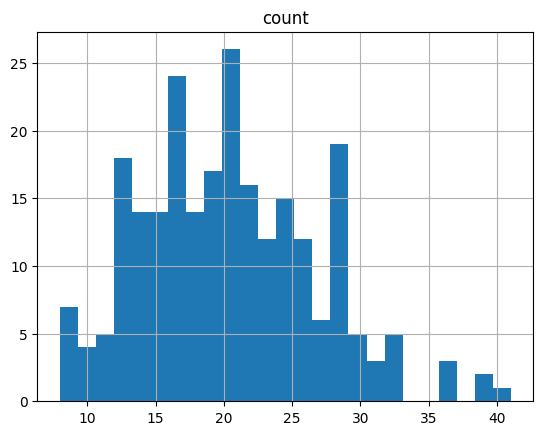

In [51]:
time_data = copy_data.sort_values(by='date_time')
time_data = time_data.reset_index(drop=True)

srch_id_ = time_data[['srch_id','day']].drop_duplicates()
srch_id_.day.value_counts()
pd.DataFrame(srch_id_.day.value_counts()).hist(bins=25);

(array([ 7.,  4.,  5., 18., 14., 14., 24., 14., 17., 26., 16., 12., 15.,
        12.,  6., 19.,  5.,  3.,  5.,  0.,  0.,  3.,  0.,  2.,  1.]),
 array([ 8.  ,  9.32, 10.64, 11.96, 13.28, 14.6 , 15.92, 17.24, 18.56,
        19.88, 21.2 , 22.52, 23.84, 25.16, 26.48, 27.8 , 29.12, 30.44,
        31.76, 33.08, 34.4 , 35.72, 37.04, 38.36, 39.68, 41.  ]),
 <BarContainer object of 25 artists>)

Text(0.5, 0, '#Arrivals')

Text(0, 0.5, '#Days')

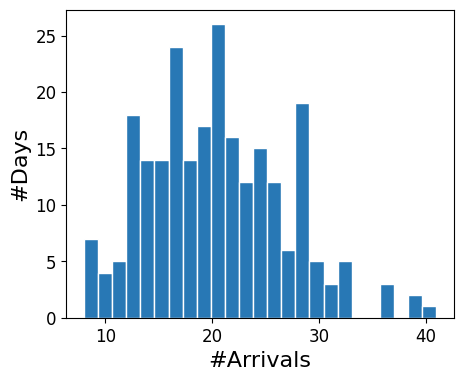

Index([2013-02-11, 2012-11-21, 2012-12-19, 2013-01-14, 2013-01-13, 2013-01-15,
       2013-01-16, 2013-01-23, 2013-04-09, 2012-11-27,
       ...
       2013-04-27, 2012-12-15, 2012-11-17, 2012-11-16, 2013-03-29, 2012-11-12,
       2013-04-28, 2012-11-10, 2013-05-10, 2013-05-25],
      dtype='object', name='day', length=212)

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
day_person_num = srch_id_.day.value_counts().values
ax.hist(day_person_num,bins=25,color='#2878B5',edgecolor='white')
ax.set_xlabel("#Arrivals",fontsize=16)
ax.set_ylabel("#Days",fontsize=16)
plt.tick_params(labelsize=12)
#plt.savefig(r'new/'+'arrivals'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')     
plt.show();
day_cusnum = pd.DataFrame(srch_id_.day.value_counts())
day_use = day_cusnum.loc[(day_cusnum['count']>11) & (day_cusnum['count']<31)].index
day_use

In [54]:
use_time_data = time_data[time_data['day'].isin(day_use)]
day_srch_type = use_time_data[['day','srch_id','cus_type']].sort_values(by='day').drop_duplicates()
day_srch_type['count'] = 1
day_type_count = day_srch_type[['day','cus_type','count']].groupby(['day','cus_type']).sum()
day_type_count

count
day        cus_type       
2012-11-01 0.0          16
           1.0           3
           3.0           3
2012-11-02 0.0          16
           2.0           2
...                    ...
2013-06-26 3.0           4
2013-06-27 0.0          16
           1.0           1
           2.0           2
           3.0           3

[754 rows x 1 columns]

In [55]:
seq = {}
i = 1
for day in use_time_data['day'].unique():
    seq[i] = list(day_srch_type[['day','cus_type']][day_srch_type[['day','cus_type']]['day']==day]['cus_type'].values)
    i += 1

In [56]:
temp_df = use_time_data[['srch_id','cus_type']].drop_duplicates()
type1_prob = len(temp_df[temp_df['cus_type']==0])/len(temp_df)
type2_prob = len(temp_df[temp_df['cus_type']==1])/len(temp_df)
type3_prob = len(temp_df[temp_df['cus_type']==2])/len(temp_df)
type4_prob = len(temp_df[temp_df['cus_type']==3])/len(temp_df)
type1_prob+type2_prob+type3_prob+type4_prob
p_ = [type1_prob,type2_prob,type3_prob,type4_prob]
for day in seq.keys():
    for i in range(80):
        seq[day].append(np.random.choice(range(0,4),size=1,p=p_)[0])

1.0

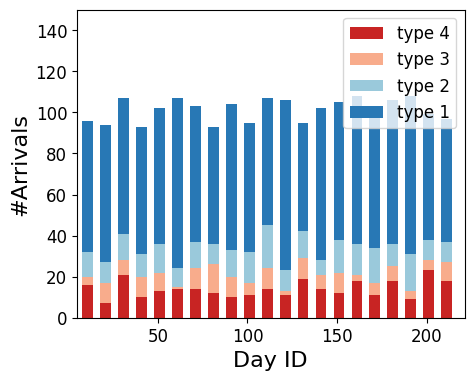

In [57]:
day_type_count = {1:list(),2:list(),3:list(),4:list()}
for day in seq.keys():
    for i in range(0,4):
        day_type_count[i+1].append(seq[day].count(i))

x = range(1,len(use_time_data['day'].unique()))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
ax.bar(x[::10],day_type_count[4][::10],width=6,label='type 4 number',color='#C82423')
ax.bar(x[::10],day_type_count[3][::10],width=6,bottom=day_type_count[4][::10],label='type 3 number',color='#F8AC8C')
ax.bar(x[::10],day_type_count[2][::10],width=6,bottom=(np.array(day_type_count[4])+np.array(day_type_count[3]))[::10]
                                            ,label='type 2 number',color='#9AC9DB')
ax.bar(x[::10],day_type_count[1][::10],width=6,bottom=(np.array(day_type_count[4])+np.array(day_type_count[3])+
                                                np.array(day_type_count[2]))[::10],label='type 1 number',color='#2878B5')
ax.set_xlabel("Day ID",fontsize=16)
ax.set_ylabel("#Arrivals",fontsize=16)
plt.xlim(5,221)
plt.ylim(0,150)
plt.tick_params(labelsize=12)
plt.legend(['type 4','type 3','type 2','type 1'],loc='upper right',prop = {'size':12})
#plt.savefig(r'new/'+'day_arrivals'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')  
plt.show();

In [58]:
seqdata = json.dumps(seq,cls=NpEncoder)  
with open('DRL_ass/seqdata_100Hotels.json', 'w') as json_file:
        json_file.write(seqdata)

74110

## 30 Hotels

In [11]:
prop_cols = ['prop_id','prop_brand_bool','prop_starrating','prop_review_score','prop_location_score1','prop_log_historical_price','price_usd']
prop_record = df_normalized[prop_cols]
prop_record = prop_record[prop_record['prop_id'].isin(prop_record.value_counts('prop_id')[:30].index)]
prop_info = prop_record.groupby('prop_id').mean()
prop_info['price_usd'].mean()
prop_info['price_usd'].var()**0.5

des8192_use = df_normalized[df_normalized['prop_id'].isin(prop_info.index)]
search_feature = des8192_use[['srch_id', 'prop_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 
         'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool']]

df_normalized = des8192_use[['srch_id', 'day', 'date_time', 'prop_id', 'booking_bool']].merge(prop_info.reset_index())
df_normalized = df_normalized.merge(search_feature)

#把prop_id对应到0到 的数
copydata = df_normalized.copy()
unique_prop = copydata['prop_id'].unique()
i = 0
for prop_id in unique_prop:
    copydata['prop_id'].loc[copydata['prop_id']==prop_id] = i
    i += 1
copydata.head()

-0.03785872975824229

0.25831650825269353

/tmp/ipykernel_2321169/3253190457.py:20: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  copydata['prop_id'].loc[copydata['prop_id']==prop_id] = i
/tmp/ipykernel_2321169/3253190457.py:20: SettingWithCopyWarning: 
A value is trying to be set on

,srch_id,day,date_time,prop_id,booking_bool,prop_brand_bool,prop_starrating,prop_review_score,prop_location_score1,prop_log_historical_price,price_usd,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool
0,63,2013-05-23,2013-05-23 11:56:25,0,0,1.0,-0.007065,-0.124085,0.834219,-0.003585,-0.024670,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
1,63,2013-05-23,2013-05-23 11:56:25,1,0,0.0,-0.007065,-0.124085,0.011877,-0.060423,-0.206871,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
2,63,2013-05-23,2013-05-23 11:56:25,2,0,1.0,1.199270,-0.124085,0.505282,0.129882,0.133444,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
3,63,2013-05-23,2013-05-23 11:56:25,3,0,1.0,1.199270,0.928968,0.834219,0.284044,0.286850,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0
4,63,2013-05-23,2013-05-23 11:56:25,4,0,1.0,1.199270,0.928968,0.143451,0.270786,0.324241,0.804914,-0.432114,0.773877,-0.408789,-0.324566,0


In [16]:
copydata_ = copydata.copy()
copydata_['count'] = 1
copydata_ = copydata_[['srch_id','count']]
pd.DataFrame(copydata_.groupby('srch_id').sum()['count']).describe()

,count
count,4922.000000
mean,24.622308
std,6.740176
min,2.000000
25%,25.000000
50%,27.000000
75%,29.000000
max,30.000000


In [60]:
unique_srch_feature = copydata[['srch_length_of_stay', 'srch_booking_window',
            'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool']].drop_duplicates()
len(unique_srch_feature)
len(np.unique(copydata['srch_id']))

from sklearn.cluster import KMeans
num_clusters = 4
# Perform k-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data = np.array(unique_srch_feature)
kmeans.fit(data)
labels = kmeans.labels_

type_feature = [[],[],[],[]]
for i,t in enumerate(labels):
    type_feature[t].append(data[i])
for t in range(4):
    np.save('DRL_ass/cue_feature_30Hotels_type_'+str(t)+'.npy',np.array(type_feature[t]))

len(labels)
des8192_custype = pd.DataFrame(np.concatenate((data, labels[:, np.newaxis]), axis=1), columns=['srch_length_of_stay', 'srch_booking_window',
            'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'cus_type'])
use_data = copydata.merge(des8192_custype)
len(np.unique(use_data['srch_id']))

use_data1 = use_data[use_data['cus_type']==0]
use_data2 = use_data[use_data['cus_type']==1]
use_data3 = use_data[use_data['cus_type']==2]
use_data4 = use_data[use_data['cus_type']==3]

copy_data = use_data.copy()
type1234 = [use_data1,use_data2,use_data3,use_data4]
for i,type_ in enumerate(type1234):
    type_['type1'] = 0
    type_['type2'] = 0
    type_['type3'] = 0
    type_['type4'] = 0
    type_['type'+str(i+1)] = 1
copy_data = pd.concat(type1234)
copy_data

save_data = copy_data.drop(columns=['day','date_time','cus_type'])
save_data.to_csv('DRL_ass/trans_data_30Hotels.csv')
len(save_data['prop_id'].unique())

2189

4922

KMeans(n_clusters=4, random_state=42)

2189

4922

/tmp/ipykernel_463815/2067950640.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_['type1'] = 0
/tmp/ipykernel_463815/2067950640.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_['type2'] = 0
/tmp/ipykernel_463815/2067950640.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

,srch_id,day,date_time,prop_id,booking_bool,prop_brand_bool,prop_starrating,prop_review_score,prop_location_score1,prop_log_historical_price,...,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,cus_type,type1,type2,type3,type4
13,90,2013-04-23,2013-04-23 11:12:24,0,0,1.0,-0.007065,-0.124085,0.834219,-0.003585,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
14,90,2013-04-23,2013-04-23 11:12:24,13,0,1.0,-0.007065,-0.124085,-1.402552,0.091845,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
15,90,2013-04-23,2013-04-23 11:12:24,1,0,0.0,-0.007065,-0.124085,0.011877,-0.060423,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
16,90,2013-04-23,2013-04-23 11:12:24,14,0,1.0,-0.007065,-0.124085,0.867112,0.018536,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
17,90,2013-04-23,2013-04-23 11:12:24,15,0,1.0,-0.007065,-1.177139,-0.284167,-0.081790,...,-0.104873,-1.191121,-0.408789,-0.324566,1,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121099,665178,2013-02-23,2013-02-23 12:27:10,11,0,1.0,-0.007065,-0.124085,0.505282,-0.006934,...,0.394599,-0.208622,1.085744,-0.324566,0,3.0,0,0,0,1
121100,665178,2013-02-23,2013-02-23 12:27:10,26,0,1.0,-0.007065,0.928968,-1.402552,-0.136700,...,0.394599,-0.208622,1.085744,-0.324566,0,3.0,0,0,0,1
121101,665178,2013-02-23,2013-02-23 12:27:10,27,0,1.0,-0.007065,-0.124085,0.702644,-0.167828,...,0.394599,-0.208622,1.085744,-0.324566,0,3.0,0,0,0,1
121102,665178,2013-02-23,2013-02-23 12:27:10,28,0,1.0,-1.213400,-1.177139,-0.909147,-0.339603,...,0.394599,-0.208622,1.085744,-0.324566,0,3.0,0,0,0,1


30

day
2012-12-27    41
2013-01-07    39
2013-03-18    39
2013-03-05    36
2013-01-08    36
              ..
2013-05-26     9
2013-02-03     9
2013-06-28     8
2013-03-30     8
2013-06-29     8
Name: count, Length: 242, dtype: int64

array([[<AxesSubplot: title={'center': 'count'}>]], dtype=object)

(array([ 7.,  4.,  6., 17., 14., 14., 24., 14., 17., 26., 16., 13., 14.,
        12.,  6., 19.,  5.,  3.,  5.,  0.,  0.,  3.,  0.,  2.,  1.]),
 array([ 8.  ,  9.32, 10.64, 11.96, 13.28, 14.6 , 15.92, 17.24, 18.56,
        19.88, 21.2 , 22.52, 23.84, 25.16, 26.48, 27.8 , 29.12, 30.44,
        31.76, 33.08, 34.4 , 35.72, 37.04, 38.36, 39.68, 41.  ]),
 <BarContainer object of 25 artists>)

Text(0.5, 0, '#Arrivals')

Text(0, 0.5, '#Days')

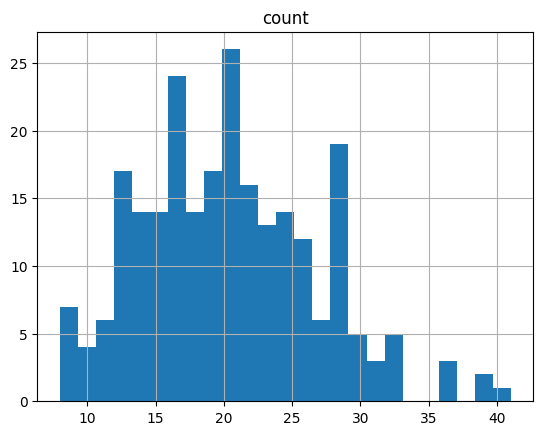

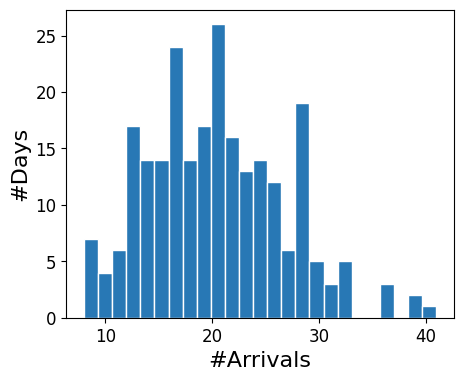

Index([2013-01-13, 2012-12-19, 2013-02-11, 2013-01-14, 2012-11-21, 2013-01-16,
       2013-01-15, 2013-04-09, 2013-01-23, 2013-03-12,
       ...
       2013-02-01, 2013-04-27, 2012-12-15, 2012-11-16, 2013-03-29, 2013-05-10,
       2012-11-12, 2013-04-28, 2012-11-10, 2013-05-25],
      dtype='object', name='day', length=211)

count
day        cus_type       
2012-11-01 0.0          16
           1.0           3
           3.0           3
2012-11-02 0.0          16
           2.0           2
...                    ...
2013-06-26 3.0           4
2013-06-27 0.0          16
           1.0           1
           2.0           2
           3.0           3

[749 rows x 1 columns]

0.9999999999999999

<BarContainer object of 22 artists>

<BarContainer object of 22 artists>

<BarContainer object of 22 artists>

<BarContainer object of 22 artists>

Text(0.5, 0, 'Day ID')

Text(0, 0.5, '#Arrivals')

(5.0, 211.0)

(0.0, 150.0)

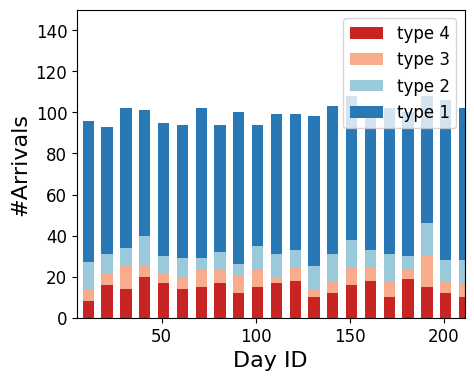

73791

In [61]:
time_data = copy_data.sort_values(by='date_time')
time_data = time_data.reset_index(drop=True)

srch_id_ = time_data[['srch_id','day']].drop_duplicates()
srch_id_.day.value_counts()
pd.DataFrame(srch_id_.day.value_counts()).hist(bins=25);

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
day_person_num = srch_id_.day.value_counts().values
ax.hist(day_person_num,bins=25,color='#2878B5',edgecolor='white')
ax.set_xlabel("#Arrivals",fontsize=16)
ax.set_ylabel("#Days",fontsize=16)
plt.tick_params(labelsize=12)
#plt.savefig(r'new/'+'arrivals'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')     
plt.show();
day_cusnum = pd.DataFrame(srch_id_.day.value_counts())
day_use = day_cusnum.loc[(day_cusnum['count']>11) & (day_cusnum['count']<31)].index
day_use

use_time_data = time_data[time_data['day'].isin(day_use)]
day_srch_type = use_time_data[['day','srch_id','cus_type']].sort_values(by='day').drop_duplicates()
day_srch_type['count'] = 1
day_type_count = day_srch_type[['day','cus_type','count']].groupby(['day','cus_type']).sum()
day_type_count

seq = {}
i = 1
for day in use_time_data['day'].unique():
    seq[i] = list(day_srch_type[['day','cus_type']][day_srch_type[['day','cus_type']]['day']==day]['cus_type'].values)
    i += 1

temp_df = use_time_data[['srch_id','cus_type']].drop_duplicates()
type1_prob = len(temp_df[temp_df['cus_type']==0])/len(temp_df)
type2_prob = len(temp_df[temp_df['cus_type']==1])/len(temp_df)
type3_prob = len(temp_df[temp_df['cus_type']==2])/len(temp_df)
type4_prob = len(temp_df[temp_df['cus_type']==3])/len(temp_df)
type1_prob+type2_prob+type3_prob+type4_prob
p_ = [type1_prob,type2_prob,type3_prob,type4_prob]
for day in seq.keys():
    for i in range(80):
        seq[day].append(np.random.choice(range(0,4),size=1,p=p_)[0])

day_type_count = {1:list(),2:list(),3:list(),4:list()}
for day in seq.keys():
    for i in range(0,4):
        day_type_count[i+1].append(seq[day].count(i))

x = range(1,len(use_time_data['day'].unique())+1)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
ax.bar(x[::10],day_type_count[4][::10],width=6,label='type 4 number',color='#C82423')
ax.bar(x[::10],day_type_count[3][::10],width=6,bottom=day_type_count[4][::10],label='type 3 number',color='#F8AC8C')
ax.bar(x[::10],day_type_count[2][::10],width=6,bottom=(np.array(day_type_count[4])+np.array(day_type_count[3]))[::10]
                                            ,label='type 2 number',color='#9AC9DB')
ax.bar(x[::10],day_type_count[1][::10],width=6,bottom=(np.array(day_type_count[4])+np.array(day_type_count[3])+
                                                np.array(day_type_count[2]))[::10],label='type 1 number',color='#2878B5')
ax.set_xlabel("Day ID",fontsize=16)
ax.set_ylabel("#Arrivals",fontsize=16)
plt.xlim(5,len(use_time_data['day'].unique()))
plt.ylim(0,150)
plt.tick_params(labelsize=12)
plt.legend(['type 4','type 3','type 2','type 1'],loc='upper right',prop = {'size':12})
plt.savefig(r'DRL_ass/'+'day_arrivals_30Hotels'+'.pdf', dpi=600, format='pdf',bbox_inches = 'tight')  
plt.show();

seqdata = json.dumps(seq,cls=NpEncoder)  
with open('DRL_ass/seqdata_30Hotels.json', 'w') as json_file:
        json_file.write(seqdata)